# Decision Trees

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Load data

In [2]:
train = pd.read_csv("res/train.csv")
test = pd.read_csv("res/test.csv")
IDtest = test["PassengerId"]

### Data Cleaning
- [参考: introduction-to-ensembling-stacking-in-python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) 

In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

<ipython-input-3-f22d94c73083>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


# Trainer

In [6]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)

x_train (891, 11)
y_train (891,)
x_test (418, 11)


In [7]:
rf = RandomForestClassifier(n_estimators=100,
                           max_depth=3,
                           max_features='auto',
                           min_samples_leaf=4,
                           bootstrap=True,
                           n_jobs=-1,
                           random_state=0)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=4, n_jobs=-1,
                       random_state=0)

In [8]:
print(rf.estimators_[0])
print(rf.estimators_[1])

DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=4,
                       random_state=209652396)
DecisionTreeClassifier(max_depth=3, max_features='auto', min_samples_leaf=4,
                       random_state=398764591)


In [9]:
y_test = rf.predict(x_test)

### まずは何の変哲もない推論結果を提出してみる

In [10]:
submission_df = pd.DataFrame({
    "PassengerID": IDtest,
    "Survived"   : y_test    
})
submission_df.to_csv('simple_random_forest_submission.csv', index=False)

[Text(0.5, 0.875, 'Pclass <= 2.5\ngini = 0.466\nsamples = 571\nvalue = [562, 329]\nclass = S'),
 Text(0.25, 0.625, 'Sex <= 0.5\ngini = 0.494\nsamples = 252\nvalue = [173, 217]\nclass = u'),
 Text(0.125, 0.375, 'FamilySize <= 3.5\ngini = 0.174\nsamples = 110\nvalue = [16, 150]\nclass = u'),
 Text(0.0625, 0.125, 'gini = 0.129\nsamples = 98\nvalue = [10, 134]\nclass = u'),
 Text(0.1875, 0.125, 'gini = 0.397\nsamples = 12\nvalue = [6, 16]\nclass = u'),
 Text(0.375, 0.375, 'Name_length <= 28.5\ngini = 0.419\nsamples = 142\nvalue = [157, 67]\nclass = S'),
 Text(0.3125, 0.125, 'gini = 0.328\nsamples = 105\nvalue = [123, 32]\nclass = S'),
 Text(0.4375, 0.125, 'gini = 0.5\nsamples = 37\nvalue = [34, 35]\nclass = u'),
 Text(0.75, 0.625, 'Title <= 1.5\ngini = 0.347\nsamples = 319\nvalue = [389, 112]\nclass = S'),
 Text(0.625, 0.375, 'FamilySize <= 1.5\ngini = 0.179\nsamples = 205\nvalue = [291, 32]\nclass = S'),
 Text(0.5625, 0.125, 'gini = 0.201\nsamples = 167\nvalue = [235, 30]\nclass = S'),
 T

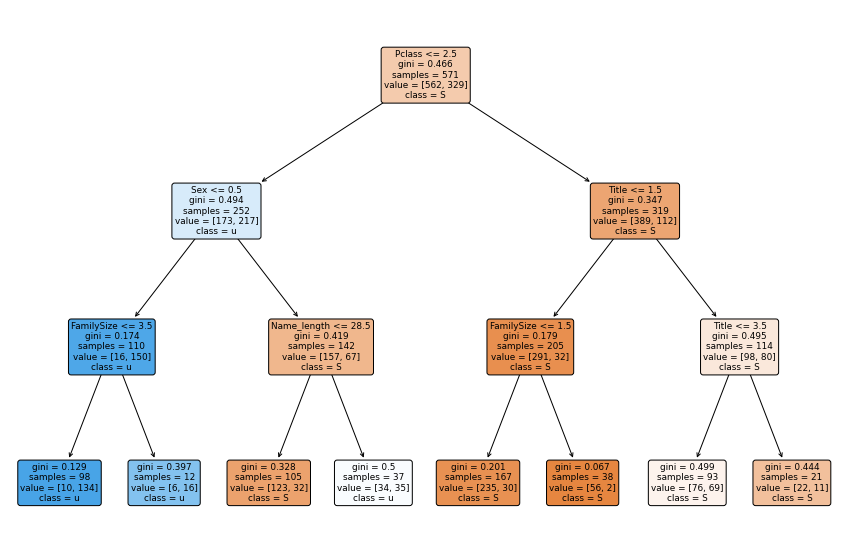

In [11]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], 
          feature_names=train.columns,
          class_names="Survived", 
          filled=True,
          impurity=True, 
          rounded=True)

# Optuna を使って最適化してみる

In [12]:
import optuna



# X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, train_size=0.8)


In [13]:
def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    bootstrap = trial.suggest_categorical('bootstrap', ['True', 'False'])
    max_depth = trial.suggest_int('max_depth', 1, 1000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 1000)
    n_estimators = trial.suggest_int('n_estimators', 1, 1000)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    NFOLDS = trial.suggest_int('NFOLDS', 2, 10)
    
    rf = RandomForestClassifier(bootstrap = bootstrap,
                               criterion = criterion,
                               max_depth = max_depth, 
                               max_features = max_features,
                               max_leaf_nodes = max_leaf_nodes,
                               n_estimators = n_estimators,
                               min_samples_split = min_samples_split,
                               min_samples_leaf = min_samples_leaf,
                               n_jobs=2
                              )
    
    kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=0)
    
    oof_train = np.zeros((len(x_train),))
    # oof_test = np.zeros((len(x_test),))
    # oof_test_skf = np.empty((NFOLDS, len(x_test)))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        rf.fit(x_tr, y_tr)

        oof_train[test_index] = rf.predict(x_te)
        # oof_test_skf[i, :] = rf.predict(x_test)

    # oof_test[:] = oof_test_skf.mean(axis=0)
    
    score = accuracy_score(y_train, oof_train)

    # rf.fit(X_train, Y_train)
    # Y_pred = rf.predict(X_test)
    
    # score = cross_val_score(rf, x_train, y_train, cv=5, scoring="r2")
    # score = accuracy_score(Y_test, Y_pred)
    # print('score', score)
                           
    return score
    
    
    

In [14]:
#optunaで学習
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-01-25 02:17:21,274] A new study created in memory with name: no-name-3c774983-eca8-49dc-b98b-b2f5579ce695
[I 2022-01-25 02:17:33,217] Trial 0 finished with value: 0.8226711560044894 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 168, 'max_features': 'auto', 'max_leaf_nodes': 277, 'n_estimators': 999, 'min_samples_split': 2, 'min_samples_leaf': 3, 'NFOLDS': 8}. Best is trial 0 with value: 0.8226711560044894.
[I 2022-01-25 02:17:33,385] Trial 1 finished with value: 0.8170594837261503 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 288, 'max_features': 'sqrt', 'max_leaf_nodes': 735, 'n_estimators': 48, 'min_samples_split': 2, 'min_samples_leaf': 5, 'NFOLDS': 2}. Best is trial 0 with value: 0.8226711560044894.
[I 2022-01-25 02:17:35,520] Trial 2 finished with value: 0.8215488215488216 and parameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 878, 'max_features': 'sqrt', 'max_leaf_nodes': 982, 'n_estimators': 177

In [17]:
# チューニングしたハイパーパラメーターをフィット
params = study.best_params
# optimised_rf = RandomForestClassifier(**params)
# optimised_rf.fit(x_train, y_train)

optimised_rf = RandomForestClassifier(bootstrap = study.best_params['bootstrap'],
                                     criterion = study.best_params['criterion'],
                                     max_depth = study.best_params['max_depth'], 
                                     max_features = study.best_params['max_features'],
                                     max_leaf_nodes = study.best_params['max_leaf_nodes'],
                                     n_estimators = study.best_params['n_estimators'],
                                     min_samples_split = study.best_params['min_samples_split'],
                                     min_samples_leaf = study.best_params['min_samples_leaf'],                                     
                                     n_jobs=2)

# optimised_rf = RandomForestClassifier(**params)
optimised_rf.fit(x_train, y_train)


RandomForestClassifier(bootstrap='False', criterion='entropy', max_depth=325,
                       max_features='log2', max_leaf_nodes=919,
                       min_samples_leaf=6, min_samples_split=3,
                       n_estimators=922, n_jobs=2)

In [18]:
y_test = optimised_rf.predict(x_test)

In [19]:
submission_df = pd.DataFrame({
    "PassengerID": IDtest,
    "Survived"   : y_test
})

submission_df.to_csv('optimised_random_forest_submission.csv', index=False)
# Score: 0.78229